In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import keras
from keras.utils import plot_model

In [ ]:
# 設定隨機種子以確保結果可重現
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 讀取檔案
input_file = '3dData_256.xlsx'
# input_file = 'output.xlsx'
output_file = 'elecData.xlsx'

input_data = pd.read_excel(input_file, engine='openpyxl').to_numpy().T
output_data = pd.read_excel(output_file, engine='openpyxl').to_numpy().T

print(f"輸入數據形狀: {input_data.shape}")
print(f"輸出數據形狀: {output_data.shape}")

輸入數據形狀: (343, 1339)
輸出數據形狀: (343, 1339)


[237 116 113]


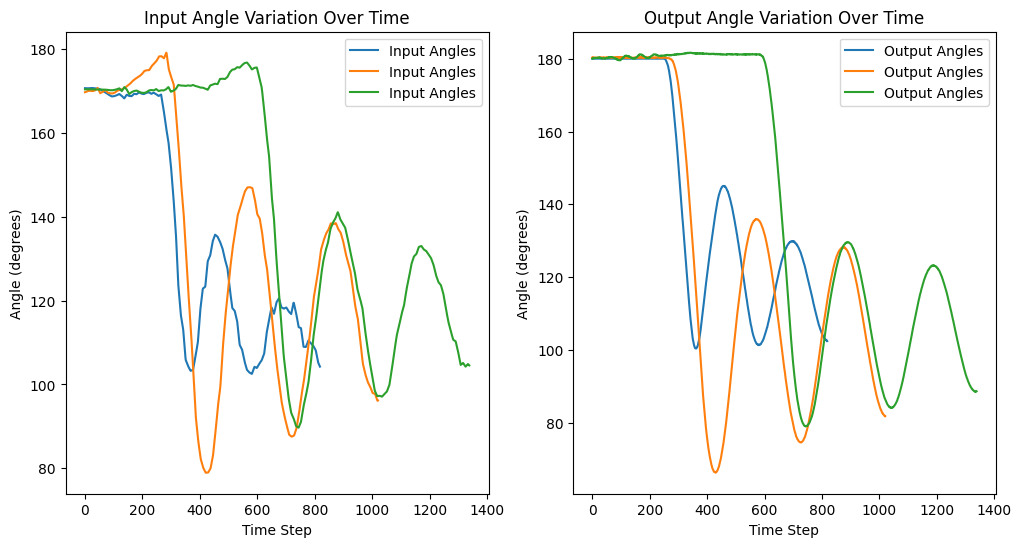

In [ ]:
# 隨機選擇幾個數據點來繪製
random_idx = np.random.choice(input_data.shape[0], size=3, replace=False)
print(random_idx)

# 繪製角度變化圖
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(input_data[random_idx].T, label='Input Angles')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Angle (degrees)')
axes[0].set_title('Input Angle Variation Over Time')
axes[0].legend()

axes[1].plot(output_data[random_idx].T, label='Output Angles')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Angle (degrees)')
axes[1].set_title('Output Angle Variation Over Time')
axes[1].legend()

plt.show()

In [ ]:
# 資料預處理 - 插值
def interpolate_ignore_nans(data, target_length, kind='linear'):
    def interpolate_row(row):
        mask = ~np.isnan(row)
        x_old = np.arange(len(row))
        if np.sum(mask) > 1:
            x_valid = x_old[mask]
            y_valid = row[mask]
            f = interp1d(x_valid, y_valid, kind=kind, fill_value="extrapolate")
            x_new = np.linspace(0, len(x_valid) - 1, target_length)
            return f(x_new)
        else:
            return np.full(target_length, np.nan)
    return np.apply_along_axis(interpolate_row, axis=1, arr=data)

input_length = 1000
output_length = 1000

input_data_interp = interpolate_ignore_nans(input_data, input_length, kind='linear')
output_data_interp = interpolate_ignore_nans(output_data, output_length, kind='linear')

print(f"插值後輸入數據形狀: {input_data_interp.shape}")
print(f"插值後輸出數據形狀: {output_data_interp.shape}")

插值後輸入數據形狀: (343, 1000)
插值後輸出數據形狀: (343, 1000)


In [ ]:
# 標準化
def normalize_data(data):
    std_dev = data.std(axis=1, keepdims=True)
    return (data - data.mean(axis=1, keepdims=True)) / (std_dev + 1e-8)

input_data_norm = normalize_data(input_data_interp)
output_data_norm = normalize_data(output_data_interp)

In [ ]:
# 切分資料集
X_temp, X_test, y_temp, y_test = train_test_split(input_data_norm, output_data_norm, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("訓練集大小:", X_train.shape[0])
print("驗證集大小:", X_val.shape[0])
print("測試集大小:", X_test.shape[0])

訓練集大小: 205
驗證集大小: 69
測試集大小: 69


In [ ]:
# 數據增強函數
def jittering(data, sigma=0.03):
    noise = np.random.normal(loc=0, scale=sigma, size=data.shape)
    return data + noise

def add_gaussian_noise(data, sigma=0.01):
    noise = np.random.normal(loc=0, scale=sigma, size=data.shape)
    return data + noise

def augment_data(X, y, num_augmentations=1):
    X_aug, y_aug = [], []

    for _ in range(num_augmentations):
        X_jittered = jittering(X)
        X_noised = add_gaussian_noise(X)

        X_aug.extend([X_jittered, X_noised])
        y_aug.extend([y, y])

    X_aug = np.concatenate([X] + X_aug)
    y_aug = np.concatenate([y] + y_aug)

    return X_aug, y_aug

# 對訓練數據進行增強
# X_train_aug, y_train_aug = augment_data(X_train, y_train, num_augmentations=1)
X_train_aug, y_train_aug = X_train, y_train

print("原始訓練集大小:", X_train.shape[0])
print("增強後訓練集大小:", X_train_aug.shape[0])
print("驗證集大小:", X_val.shape[0])
print("測試集大小:", X_test.shape[0])

原始訓練集大小: 205
增強後訓練集大小: 205
驗證集大小: 69
測試集大小: 69


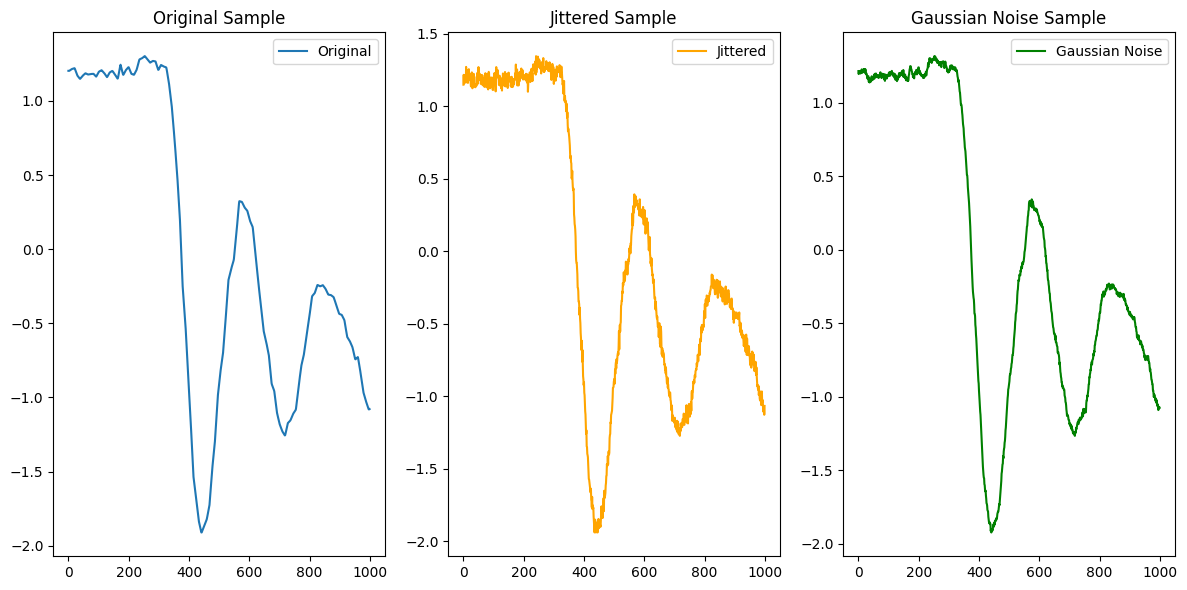

In [ ]:
#@title view for noise variation

# 假設 X_train 是一維數據序列
# 選取一個樣本來進行比較
sample_idx = 20  # 可以修改為你感興趣的索引
original_sample = X_train[sample_idx]
jittered_sample = jittering(original_sample)
noised_sample = add_gaussian_noise(original_sample)

# 繪製原始樣本與添加噪音後的樣本進行比較
plt.figure(figsize=(12, 6))

# 繪製原始數據
plt.subplot(1, 3, 1)
plt.plot(original_sample, label='Original')
plt.title('Original Sample')
plt.legend()

# 繪製 Jittering 增強的數據
plt.subplot(1, 3, 2)
plt.plot(jittered_sample, label='Jittered', color='orange')
plt.title('Jittered Sample')
plt.legend()

# 繪製 Gaussian Noise 增強的數據
plt.subplot(1, 3, 3)
plt.plot(noised_sample, label='Gaussian Noise', color='green')
plt.title('Gaussian Noise Sample')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 定義模型
input_shape = input_data_norm.shape[1]
input_layer = Input(shape=(input_shape, 1))

# 編碼器
x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# 解碼器
x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

x = Flatten()(x)
x = Dense(1000, activation='linear')(x)

autoencoder = Model(input_layer, x)
autoencoder.compile(optimizer=Adam(), loss='mse')

# 打印模型結構
autoencoder.summary()

# def build_improved_autoencoder(input_shape):
#     input_layer = Input(shape=(input_shape, 1))

#     # Encoder
#     x = Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(input_layer)
#     x = BatchNormalization()(x)
#     x = MaxPooling1D(2, padding='same')(x)
#     x = Dropout(0.2)(x)

#     x = Conv1D(16, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling1D(2, padding='same')(x)
#     x = Dropout(0.2)(x)

#     x = Conv1D(8, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
#     encoded = MaxPooling1D(2, padding='same')(x)

#     # Decoder
#     x = Conv1D(8, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(encoded)
#     x = BatchNormalization()(x)
#     x = UpSampling1D(2)(x)
#     x = Dropout(0.2)(x)

#     x = Conv1D(16, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = BatchNormalization()(x)
#     x = UpSampling1D(2)(x)
#     x = Dropout(0.2)(x)

#     x = Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = UpSampling1D(2)(x)

#     x = Flatten()(x)
#     x = Dense(2500, activation='linear')(x)

#     model = Model(input_layer, x)
#     return model

# # 使用學習率調度器
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = Adam(learning_rate=lr_schedule)

# # 使用學習率調度器
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = Adam(learning_rate=lr_schedule)

# model = build_improved_autoencoder(input_shape)
# model.compile(optimizer=optimizer, loss='mse')

# 使用早停法
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1000, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 500, 16)             │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 250, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 250, 8)              │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 125, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 125, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 250, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 250, 16)             │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 500, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 500, 32)             │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_2 (UpSampling1D)       │ (None, 1000, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      32,001,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,005,240 (122.09 MB)

 Trainable params: 32,005,240 (122.09 MB)

 Non-trainable params: 0 (0.00 B)

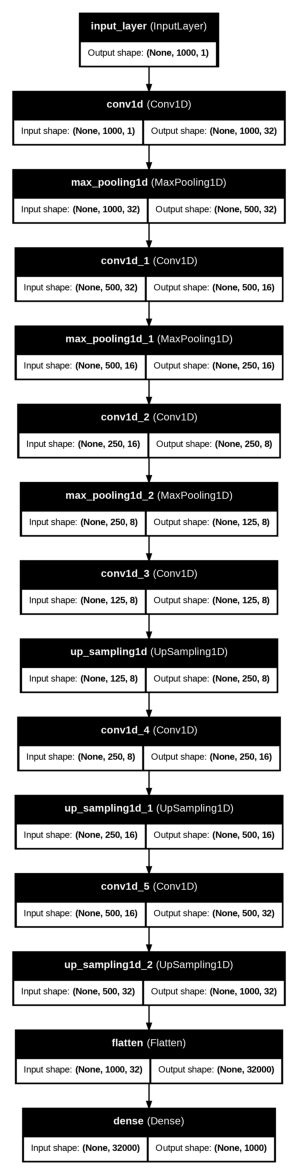

In [ ]:
# 畫出模型架構圖
keras.utils.plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

# 顯示圖片
plt.figure(figsize=(15, 15))
plt.imshow(plt.imread('autoencoder_architecture.png'))
plt.axis('off')
plt.show()

In [ ]:
# 訓練模型
# history = autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
# history = autoencoder.fit(X_train_aug, y_train_aug, epochs=50, batch_size=32, validation_data=(X_val, y_val))

history = autoencoder.fit(
    X_train_aug, y_train_aug,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    # callbacks=[early_stopping]
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - loss: 0.5797 - val_loss: 0.2574
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2100 - val_loss: 0.1398
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1305 - val_loss: 0.0920
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0777 - val_loss: 0.0598
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0496 - val_loss: 0.0462
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0401 - val_loss: 0.0404
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0330 - val_loss: 0.0353
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0286 - val_loss: 0.0313
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0257 - val_loss: 0.0291
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0236 - val_loss: 0.0275
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0215 - val_loss: 0.0266
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0198 - val_loss: 0.0255


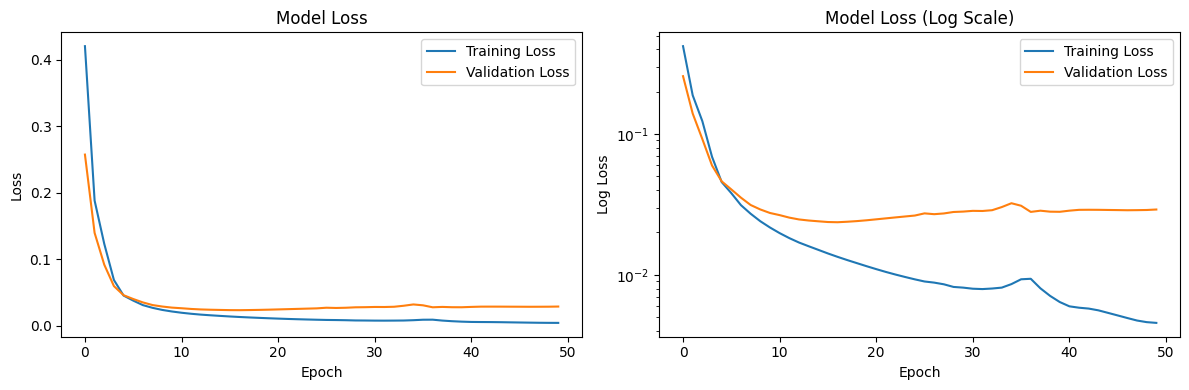

In [ ]:
# 繪製損失曲線
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 評估模型
test_loss = autoencoder.evaluate(X_test, y_test)
print(f"測試集損失: {test_loss}")

y_pred = autoencoder.predict(X_test)

mae = np.mean(np.abs(y_test - y_pred))
print(f"平均絕對誤差 (MAE): {mae}")

rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"均方根誤差 (RMSE): {rmse}")

mse = np.mean((y_test - y_pred)**2)
print(f"均方誤差 (MSE): {mse}")

# mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# print(f"平均絕對百分比誤差 (MAPE): {mape}%")

epsilon = 1e-10  # 防止除以零
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), epsilon))) * 100
print(f"平均絕對百分比誤差 (MAPE): {mape}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 
測試集損失: 0.01729230396449566
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
平均絕對誤差 (MAE): 0.09049089257514434
均方根誤差 (RMSE): 0.13150020157183065
均方誤差 (MSE): 0.01729230301343209
平均絕對百分比誤差 (MAPE): 88.69804017159133%


[63 46 60 61 40]


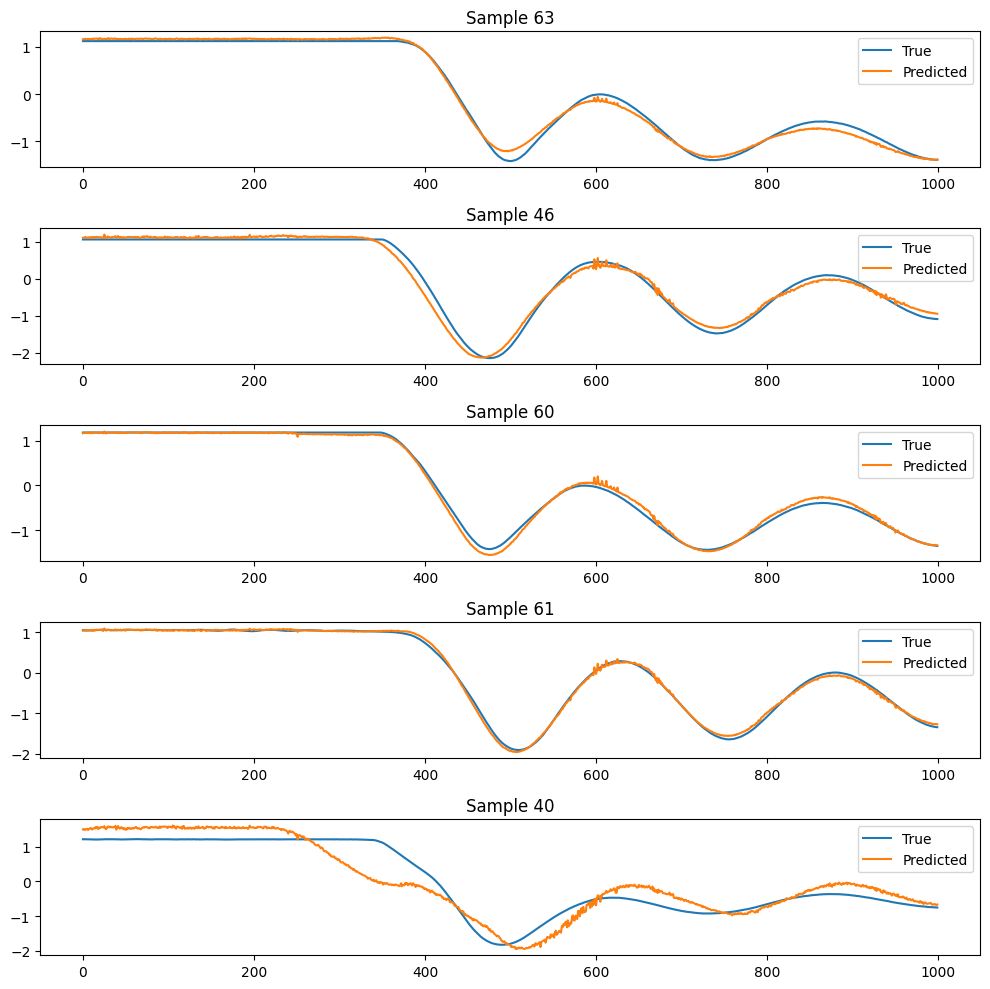

In [ ]:
# 視覺化預測結果
# n = 5  # 顯示前5個樣本
# plt.figure(figsize=(15, 10))
# for i in range(n):
#     plt.subplot(n, 1, i+1)
#     plt.plot(y_test[i], label='True')
#     plt.plot(y_pred[i], label='Predicted')
#     plt.legend()
#     plt.title(f'Sample {i+1}')
# plt.tight_layout()
# plt.show()

n = 5  # 顯示5個隨機樣本
random_indices = np.random.choice(y_test.shape[0], n, replace=False)
print(random_indices)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(n, 1, i+1)
    # plt.plot(X_test[idx], label='3d')
    plt.plot(y_test[idx], label='True')
    plt.plot(y_pred[idx], label='Predicted')
    plt.legend()
    plt.title(f'Sample {idx}')
plt.tight_layout()
plt.show()

# 拿所有數據驗證一下結果(標準化過後)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


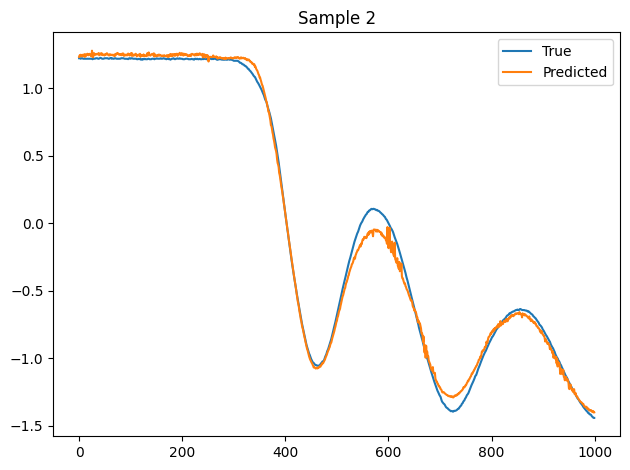

In [ ]:
#@title view for all data (normalization)
y_pred = autoencoder.predict(input_data_norm)

idx = 2

# plt.plot(input_data_norm[idx], label='Original')
plt.plot(output_data_norm[idx], label='True')
plt.plot(y_pred[idx], label='Predicted')
plt.legend()
plt.title(f'Sample {idx}')
plt.tight_layout()
plt.show()

# 拿所有數據驗證一下結果(還原比例)

In [ ]:
#@title view for all data (original)
import numpy as np
import matplotlib.pyplot as plt

def denormalize_data(normalized_data, original_data):
    # 計算原始數據的均值和標準差
    mean = original_data.mean(axis=1, keepdims=True)
    std = original_data.std(axis=1, keepdims=True)

    # 還原標準化的數據
    denormalized_data = (normalized_data * (std + 1e-8)) + mean
    return denormalized_data

# 還原所有數據
input_denorm = denormalize_data(input_data_norm, input_data_interp)
output_denorm = denormalize_data(output_data_norm, output_data_interp)
pred_denorm = denormalize_data(y_pred, output_data_interp)

# 繪製指定索引的數據
idx = 3
plt.figure(figsize=(12, 6))

# 繪製三條曲線
plt.plot(input_denorm[idx], label='Input', linestyle='--', alpha=0.7)
plt.plot(output_denorm[idx], label='True Output', linewidth=2)
plt.plot(pred_denorm[idx], label='Predicted Output', linestyle='-.', alpha=0.8)

plt.legend()
plt.title(f'Sample {idx} (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Angle (degrees)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 打印一些統計信息
print(f"\nSample {idx} Statistics:")
print(f"Input data range: {input_denorm[idx].min():.2f} to {input_denorm[idx].max():.2f}")
print(f"True output range: {output_denorm[idx].min():.2f} to {output_denorm[idx].max():.2f}")
print(f"Predicted output range: {pred_denorm[idx].min():.2f} to {pred_denorm[idx].max():.2f}")

In [ ]:
# 儲存模型
autoencoder.save('autoencoder_model.h5')
print("模型已保存為 'autoencoder_model.h5'")

模型已保存為 'autoencoder_model.h5'


# 輸入新的數據

模型載入成功
輸入數據形狀: (1, 2013)
插值後數據形狀: (1, 1000)
標準化後數據形狾: (1, 1000)
模型輸入數據形狀: (1, 1000, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
預測結果形狀: (1, 1000)
處理完成


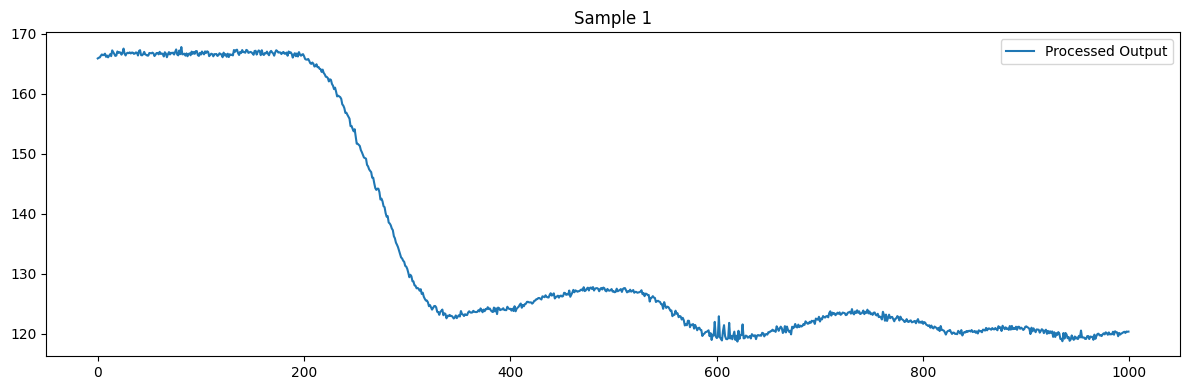

In [ ]:
#@title new data with model predict
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.interpolate import interp1d
from keras.saving import register_keras_serializable

# 註冊自定義損失函數
@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def interpolate_data(data, target_length=1000, kind='linear'):
    """將數據插值到指定長度"""
    def interpolate_row(row):
        x_old = np.arange(len(row))
        f = interp1d(x_old, row, kind=kind, fill_value="extrapolate")
        x_new = np.linspace(0, len(row)-1, target_length)
        return f(x_new)

    return np.apply_along_axis(interpolate_row, axis=1, arr=data)

def normalize_data(data):
    """標準化數據"""
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_data(normalized_data, mean, std):
    """反標準化數據"""
    return normalized_data * (std + 1e-8) + mean

def process_new_data(input_file_path, model_path):
    """處理新的數據並通過模型進行預測"""
    try:
        # 載入模型
        model = load_model(model_path, custom_objects={'mse': mse})
        print("模型載入成功")

        # 讀取新數據
        try:
            input_data = pd.read_csv(input_file_path).to_numpy().T
        except:
            input_data = pd.read_excel(input_file_path).to_numpy().T
        print(f"輸入數據形狀: {input_data.shape}")

        # 插值到1000個點
        interpolated_data = interpolate_data(input_data, target_length=1000)
        print(f"插值後數據形狀: {interpolated_data.shape}")

        # 標準化數據
        normalized_data, mean, std = normalize_data(interpolated_data)
        print(f"標準化後數據形狾: {normalized_data.shape}")

        # 重塑數據以符合模型輸入要求 (samples, timesteps, features)
        model_input = normalized_data.reshape(normalized_data.shape[0], normalized_data.shape[1], 1)
        print(f"模型輸入數據形狀: {model_input.shape}")

        # 預測
        predictions = model.predict(model_input)
        print(f"預測結果形狀: {predictions.shape}")

        # 反標準化預測結果
        denormalized_predictions = denormalize_data(predictions, mean, std)
        print("處理完成")

        return denormalized_predictions

    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        raise

def main():
    # 設定檔案路徑
    model_path = 'autoencoder_model.h5'
    new_data_path = 'test.csv'  # 或 'test.xlsx'

    # 處理數據並獲取預測結果
    predictions = process_new_data(new_data_path, model_path)

    # 儲存結果
    output_df = pd.DataFrame(predictions.T)
    output_df.to_excel('processed_output.xlsx', index=False)

    # 可視化結果
    import matplotlib.pyplot as plt

    n_samples = min(3, predictions.shape[0])  # 顯示最多3個樣本
    plt.figure(figsize=(12, 4*n_samples))
    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)
        plt.plot(predictions[i], label='Processed Output')
        plt.title(f'Sample {i+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

模型載入成功
輸入數據形狀: (1, 2013)
插值後數據形狀: (1, 1000)
標準化後數據形狾: (1, 1000)
模型輸入數據形狀: (1, 1000, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
預測結果形狀: (1, 1000)
處理完成


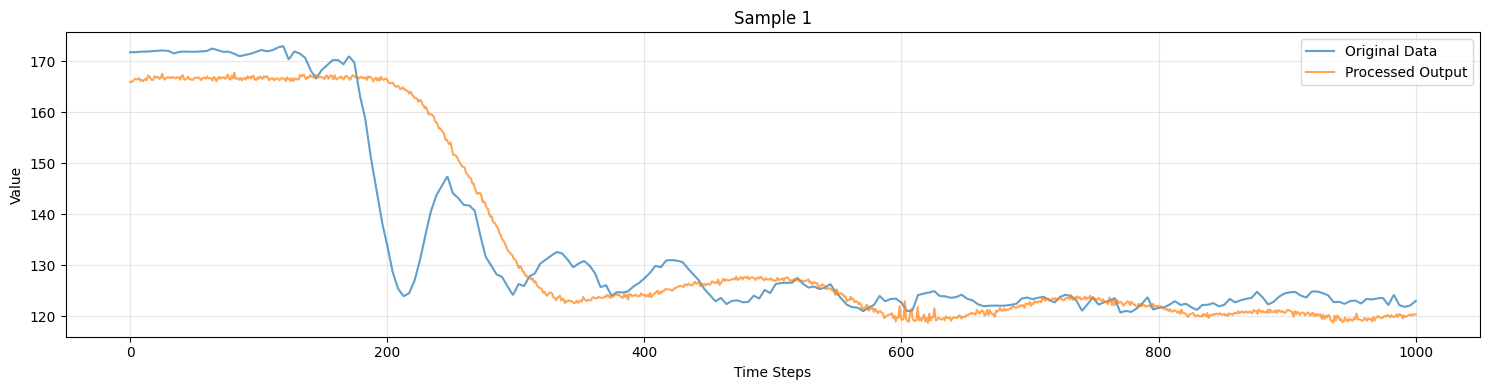


誤差統計:
MSE: 66.605242
MAE: 4.737566


In [ ]:
#@title new data with model predict (compare)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.interpolate import interp1d
from keras.saving import register_keras_serializable

# 註冊自定義損失函數
@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def interpolate_data(data, target_length=1000, kind='linear'):
    """將數據插值到指定長度"""
    def interpolate_row(row):
        x_old = np.arange(len(row))
        f = interp1d(x_old, row, kind=kind, fill_value="extrapolate")
        x_new = np.linspace(0, len(row)-1, target_length)
        return f(x_new)

    return np.apply_along_axis(interpolate_row, axis=1, arr=data)

def normalize_data(data):
    """標準化數據"""
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_data(normalized_data, mean, std):
    """反標準化數據"""
    return normalized_data * (std + 1e-8) + mean

def process_new_data(input_file_path, model_path):
    """處理新的數據並通過模型進行預測"""
    try:
        # 載入模型
        model = load_model(model_path, custom_objects={'mse': mse})
        print("模型載入成功")

        # 讀取新數據
        try:
            input_data = pd.read_csv(input_file_path).to_numpy().T
        except:
            input_data = pd.read_excel(input_file_path).to_numpy().T
        print(f"輸入數據形狀: {input_data.shape}")

        # 保存原始數據
        original_data = input_data.copy()

        # 插值到1000個點
        interpolated_data = interpolate_data(input_data, target_length=1000)
        print(f"插值後數據形狀: {interpolated_data.shape}")

        # 標準化數據
        normalized_data, mean, std = normalize_data(interpolated_data)
        print(f"標準化後數據形狀: {normalized_data.shape}")

        # 重塑數據以符合模型輸入要求 (samples, timesteps, features)
        model_input = normalized_data.reshape(normalized_data.shape[0], normalized_data.shape[1], 1)
        print(f"模型輸入數據形狀: {model_input.shape}")

        # 預測
        predictions = model.predict(model_input)
        print(f"預測結果形狀: {predictions.shape}")

        # 反標準化預測結果
        denormalized_predictions = denormalize_data(predictions, mean, std)
        print("處理完成")

        return denormalized_predictions, original_data

    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        raise

def visualize_results(predictions, original_data, n_samples=3):
    """視覺化原始數據和預測結果的比較"""
    import matplotlib.pyplot as plt

    # 決定要顯示的樣本數
    n_samples = min(n_samples, predictions.shape[0], original_data.shape[0])

    # 創建圖形
    plt.figure(figsize=(15, 4*n_samples))

    # 為原始數據和預測結果創建x軸
    x_pred = np.linspace(0, 1000, predictions.shape[1])
    x_orig = np.linspace(0, 1000, original_data.shape[1])

    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)

        # 繪製原始數據
        plt.plot(x_orig, original_data[i], label='Original Data', alpha=0.7)

        # 繪製預測結果
        plt.plot(x_pred, predictions[i], label='Processed Output', alpha=0.7)

        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    # 設定檔案路徑
    model_path = 'autoencoder_model.h5'
    new_data_path = 'test.csv'  # 或 'test.xlsx'

    # 處理數據並獲取預測結果
    predictions, original_data = process_new_data(new_data_path, model_path)

    # 儲存結果
    output_df = pd.DataFrame(predictions.T)
    output_df.to_excel('processed_output.xlsx', index=False)

    # 視覺化結果比較
    visualize_results(predictions, original_data, n_samples=3)

    # 計算誤差統計
    mse = np.mean((predictions - interpolate_data(original_data, predictions.shape[1]))**2)
    mae = np.mean(np.abs(predictions - interpolate_data(original_data, predictions.shape[1])))
    print(f'\n誤差統計:')
    print(f'MSE: {mse:.6f}')
    print(f'MAE: {mae:.6f}')

if __name__ == "__main__":
    main()

模型載入成功
原始輸入數據形狀: (1, 2013)
Baseline detected: 123.31596104323307
Inspecting index 10, value: 171.78286349048952
Inspecting index 11, value: 171.78754636695533
Inspecting index 12, value: 171.792502297626
Inspecting index 13, value: 171.79773142400668
Inspecting index 14, value: 171.80323233833641
Inspecting index 15, value: 171.80901900661956
Inspecting index 16, value: 171.81515523535205
Inspecting index 17, value: 171.82161873086744
Inspecting index 18, value: 171.82838624286157
Inspecting index 19, value: 171.83543357493522
Inspecting index 20, value: 171.84273557405123
Inspecting index 21, value: 171.85026614107747
Inspecting index 22, value: 171.85799822024381
Inspecting index 23, value: 171.86590380727645
Inspecting index 24, value: 171.8741719046895
Inspecting index 25, value: 171.88286036397906
Inspecting index 26, value: 171.8918757033108
Inspecting index 27, value: 171.90112582523932
Inspecting index 28, value: 171.91052000857403
Inspecting index 29, value: 171.9199689112502


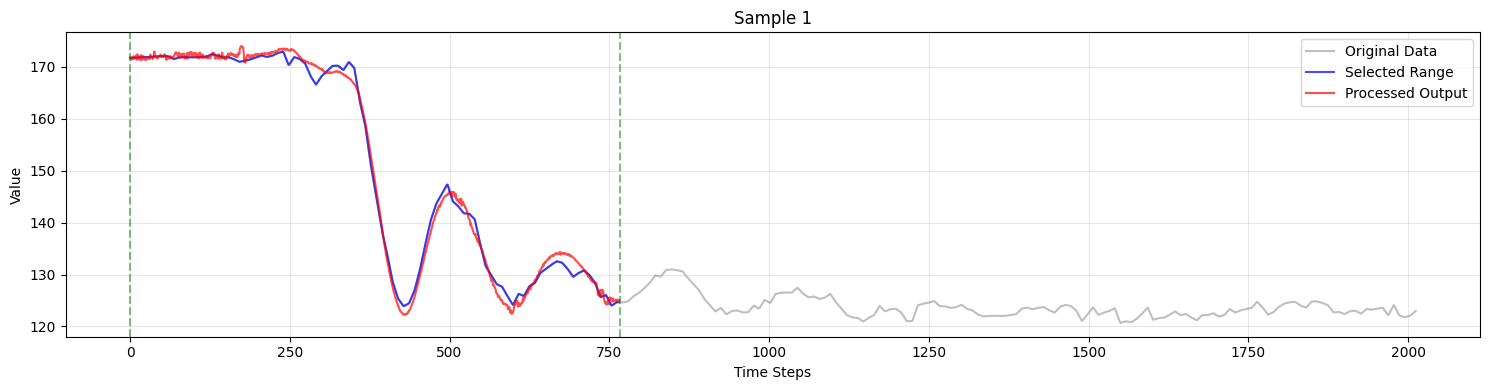


誤差統計 (僅計算選定範圍):
MSE: 6.843443
MAE: 1.915024


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.interpolate import interp1d
from keras.saving import register_keras_serializable

def detect_baseline(signal, window_size=20, high_value_threshold=170, tolerance=30):
    # 計算信號的局部變異度
    local_var = np.array([np.std(signal[max(0, i - 5):min(len(signal), i + 6)])
                          for i in range(len(signal))])

    # 找出穩定段（局部變異度小的區域）
    stable_regions = local_var < 0.5

    # 在穩定區域中尋找基準值
    valid_baselines = []

    for i in range(len(signal) - window_size):
        # 檢查是否為穩定區域
        if np.all(stable_regions[i:i + window_size]):
            current_level = np.mean(signal[i:i + window_size])

            # 檢查是否不在高角度範圍內
            if current_level < (high_value_threshold - tolerance):
                valid_baselines.append(current_level)

    if valid_baselines:
        # 返回所有有效基準值的中位數
        return np.median(valid_baselines)

    # 如果沒有找到合適的基準值，使用非高角度區域的中位數作為備選
    low_values = signal[signal < (high_value_threshold - tolerance)]
    if len(low_values) > 0:
        return np.median(low_values)

    # 如果上述方法都失敗，返回信號末端的值
    return signal[len(signal) - 3]


def get_first_two_waves(data, window_size=10, valley_threshold=150):
    """
    找到數據中完整的波 [第一波谷 -> 第二波谷 -> 第三波谷] 並返回第二波的結束位置
    新增局部最小值判斷，必須前後 window_size 個點都比當前點大，且第一個波谷必須小於 valley_threshold。
    """
    data = data.squeeze()
    baseline = detect_baseline(data)
    print(f"Baseline detected: {baseline}")

    # 初始化
    current_wave = {"first_start": None, "second_start": None, "third_start": None}
    looking_for = "valley"  # 初始狀態為尋找波谷
    valley_count = 0  # 用來追蹤已經找到的波谷數量

    for i in range(window_size, len(data) - window_size):
        print(f"Inspecting index {i}, value: {data[i]}")  # 打印每一點的數據

        if looking_for == "valley":
            # 檢查當前點是否為局部最小值
            if all(data[i] < data[i - j] and data[i] < data[i + j] for j in range(1, window_size + 1)):
                print(f"Valley count: {valley_count}")

                # 確保第一個波谷的數值小於 valley_threshold
                if valley_count == 0 and data[i] < valley_threshold:
                    current_wave["first_start"] = i  # 設定為第一個波的開始
                    valley_count += 1
                    print(f"First valley detected at index {i}, value: {data[i]}")

                # 第二個波谷（無需數值小於 valley_threshold 的限制）
                elif valley_count == 1:
                    current_wave["second_start"] = i  # 設定為第二個波的開始
                    valley_count += 1
                    print(f"Second valley detected at index {i}, value: {data[i]}")

                # 第三個波谷，作為第二波的結束點
                elif valley_count == 2:
                    current_wave["third_start"] = i  # 設定為第三個波的開始
                    valley_count += 1
                    print(f"Third valley detected at index {i}, value: {data[i]}")

                    # 第二波結束點確定，返回
                    return current_wave["third_start"]

    # 如果未找到三個波谷，返回數據長度
    print(f"Only {valley_count} valley(s) detected.")
    return len(data)

# 註冊自定義損失函數
@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def interpolate_data(data, target_length=1000, kind='linear'):
    """將數據插值到指定長度"""
    def interpolate_row(row):
        x_old = np.arange(len(row))
        f = interp1d(x_old, row, kind=kind, fill_value="extrapolate")
        x_new = np.linspace(0, len(row)-1, target_length)
        return f(x_new)

    return np.apply_along_axis(interpolate_row, axis=1, arr=data)

def normalize_data(data):
    """標準化數據"""
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_data(normalized_data, mean, std):
    """反標準化數據"""
    return normalized_data * (std + 1e-8) + mean

def process_new_data(input_file_path, model_path, start_idx=0, end_idx=None):
    """處理新的數據並通過模型進行預測"""
    try:
        # 載入模型
        model = load_model(model_path, custom_objects={'mse': mse})
        print("模型載入成功")

        # 讀取新數據
        try:
            input_data = pd.read_csv(input_file_path).to_numpy().T
        except:
            input_data = pd.read_excel(input_file_path).to_numpy().T
        print(f"原始輸入數據形狀: {input_data.shape}")

        # 保存完整原始數據
        full_original_data = input_data.copy()

        filter_data = scipy.signal.savgol_filter(full_original_data, 57, 3, mode='nearest')
        end_idx = get_first_two_waves(filter_data)

        # 截取指定範圍的數據
        if end_idx is None:
            end_idx = input_data.shape[1]
        input_data = input_data[:, start_idx:end_idx]
        print(f"截取後數據形狀: {input_data.shape}")

        # 插值到1000個點
        interpolated_data = interpolate_data(input_data, target_length=1000)
        print(f"插值後數據形狀: {interpolated_data.shape}")

        # 標準化數據
        normalized_data, mean, std = normalize_data(interpolated_data)
        print(f"標準化後數據形狀: {normalized_data.shape}")

        # 重塑數據以符合模型輸入要求 (samples, timesteps, features)
        model_input = normalized_data.reshape(normalized_data.shape[0], normalized_data.shape[1], 1)
        print(f"模型輸入數據形狀: {model_input.shape}")

        # 預測
        predictions = model.predict(model_input)
        print(f"預測結果形狀: {predictions.shape}")

        # 反標準化預測結果
        denormalized_predictions = denormalize_data(predictions, mean, std)
        print("處理完成")

        return denormalized_predictions, full_original_data, (start_idx, end_idx)

    except Exception as e:
        print(f"發生錯誤: {str(e)}")
        raise


def visualize_results(predictions, original_data, range_indices, n_samples=3):
    """視覺化原始數據和預測結果的比較"""
    import matplotlib.pyplot as plt

    start_idx, end_idx = range_indices

    # 決定要顯示的樣本數
    n_samples = min(n_samples, predictions.shape[0], original_data.shape[0])

    # 創建圖形
    plt.figure(figsize=(15, 4*n_samples))

    # 為原始數據和預測結果創建x軸
    x_full = np.arange(original_data.shape[1])
    x_pred = np.linspace(start_idx, end_idx, predictions.shape[1])

    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)

        # 繪製完整原始數據
        plt.plot(x_full, original_data[i], label='Original Data', alpha=0.5, color='gray')

        # 突出顯示處理的部分
        plt.plot(x_full[start_idx:end_idx],
                original_data[i, start_idx:end_idx],
                label='Selected Range',
                color='blue',
                alpha=0.7)

        # 繪製預測結果
        plt.plot(x_pred, predictions[i],
                label='Processed Output',
                color='red',
                alpha=0.7)

        # 添加垂直線標示處理範圍
        plt.axvline(x=start_idx, color='green', linestyle='--', alpha=0.5)
        plt.axvline(x=end_idx, color='green', linestyle='--', alpha=0.5)

        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    # 設定檔案路徑
    model_path = 'autoencoder_model.h5'
    new_data_path = 'test.csv'  # 或 'test.xlsx'

    # 設定要處理的數據範圍
    start_idx = 0  # 起始索引
    end_idx = 750  # 結束索引，設為None則處理到結尾

    # 處理數據並獲取預測結果
    predictions, original_data, range_indices = process_new_data(
        new_data_path,
        model_path,
        start_idx=start_idx,
        end_idx=end_idx
    )

    # 儲存結果
    output_df = pd.DataFrame(predictions.T)
    output_df.to_excel('processed_output.xlsx', index=False)

    # 視覺化結果比較
    visualize_results(predictions, original_data, range_indices, n_samples=3)

    # 計算指定範圍內的誤差統計
    original_selected = original_data[:, start_idx:end_idx]
    original_interp = interpolate_data(original_selected, predictions.shape[1])

    mse = np.mean((predictions - original_interp)**2)
    mae = np.mean(np.abs(predictions - original_interp))
    print(f'\n誤差統計 (僅計算選定範圍):')
    print(f'MSE: {mse:.6f}')
    print(f'MAE: {mae:.6f}')

if __name__ == "__main__":
    main()

原始輸入數據形狀: (1, 2013)
Baseline detected: 123.31596104323307
Inspecting index 10, value: 171.78286349048952
Inspecting index 11, value: 171.78754636695533
Inspecting index 12, value: 171.792502297626
Inspecting index 13, value: 171.79773142400668
Inspecting index 14, value: 171.80323233833641
Inspecting index 15, value: 171.80901900661956
Inspecting index 16, value: 171.81515523535205
Inspecting index 17, value: 171.82161873086744
Inspecting index 18, value: 171.82838624286157
Inspecting index 19, value: 171.83543357493522
Inspecting index 20, value: 171.84273557405123
Inspecting index 21, value: 171.85026614107747
Inspecting index 22, value: 171.85799822024381
Inspecting index 23, value: 171.86590380727645
Inspecting index 24, value: 171.8741719046895
Inspecting index 25, value: 171.88286036397906
Inspecting index 26, value: 171.8918757033108
Inspecting index 27, value: 171.90112582523932
Inspecting index 28, value: 171.91052000857403
Inspecting index 29, value: 171.9199689112502
Inspect

<Figure size 1500x400 with 0 Axes>

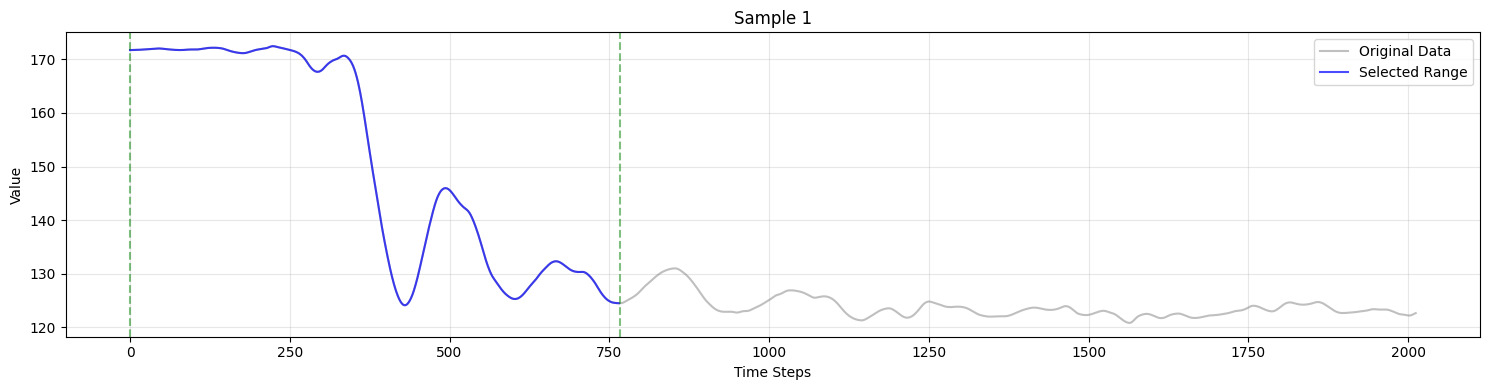

In [ ]:
#@title find two waves end index (test)
import numpy as np
import scipy
from scipy.signal import find_peaks
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy.fftpack import fft, fftfreq
import scipy.signal

def detect_baseline(signal, window_size=20, high_value_threshold=170, tolerance=30):
    # 計算信號的局部變異度
    local_var = np.array([np.std(signal[max(0, i - 5):min(len(signal), i + 6)])
                          for i in range(len(signal))])

    # 找出穩定段（局部變異度小的區域）
    stable_regions = local_var < 0.5

    # 在穩定區域中尋找基準值
    valid_baselines = []

    for i in range(len(signal) - window_size):
        # 檢查是否為穩定區域
        if np.all(stable_regions[i:i + window_size]):
            current_level = np.mean(signal[i:i + window_size])

            # 檢查是否不在高角度範圍內
            if current_level < (high_value_threshold - tolerance):
                valid_baselines.append(current_level)

    if valid_baselines:
        # 返回所有有效基準值的中位數
        return np.median(valid_baselines)

    # 如果沒有找到合適的基準值，使用非高角度區域的中位數作為備選
    low_values = signal[signal < (high_value_threshold - tolerance)]
    if len(low_values) > 0:
        return np.median(low_values)

    # 如果上述方法都失敗，返回信號末端的值
    return signal[len(signal) - 3]


def get_first_two_waves(data, window_size=10, valley_threshold=150):
    """
    找到數據中完整的波 [第一波谷 -> 第二波谷 -> 第三波谷] 並返回第二波的結束位置
    新增局部最小值判斷，必須前後 window_size 個點都比當前點大，且第一個波谷必須小於 valley_threshold。
    """
    data = data.squeeze()
    baseline = detect_baseline(data)
    print(f"Baseline detected: {baseline}")

    # 初始化
    current_wave = {"first_start": None, "second_start": None, "third_start": None}
    looking_for = "valley"  # 初始狀態為尋找波谷
    valley_count = 0  # 用來追蹤已經找到的波谷數量

    for i in range(window_size, len(data) - window_size):
        print(f"Inspecting index {i}, value: {data[i]}")  # 打印每一點的數據

        if looking_for == "valley":
            # 檢查當前點是否為局部最小值
            if all(data[i] < data[i - j] and data[i] < data[i + j] for j in range(1, window_size + 1)):
                print(f"Valley count: {valley_count}")

                # 確保第一個波谷的數值小於 valley_threshold
                if valley_count == 0 and data[i] < valley_threshold:
                    current_wave["first_start"] = i  # 設定為第一個波的開始
                    valley_count += 1
                    print(f"First valley detected at index {i}, value: {data[i]}")

                # 第二個波谷（無需數值小於 valley_threshold 的限制）
                elif valley_count == 1:
                    current_wave["second_start"] = i  # 設定為第二個波的開始
                    valley_count += 1
                    print(f"Second valley detected at index {i}, value: {data[i]}")

                # 第三個波谷，作為第二波的結束點
                elif valley_count == 2:
                    current_wave["third_start"] = i  # 設定為第三個波的開始
                    valley_count += 1
                    print(f"Third valley detected at index {i}, value: {data[i]}")

                    # 第二波結束點確定，返回
                    return current_wave["third_start"]

    # 如果未找到三個波谷，返回數據長度
    print(f"Only {valley_count} valley(s) detected.")
    return len(data)



def interpolate_data(data, target_length=1000, kind='linear'):
    """將數據插值到指定長度"""
    def interpolate_row(row):
        x_old = np.arange(len(row))
        f = interp1d(x_old, row, kind=kind, fill_value="extrapolate")
        x_new = np.linspace(0, len(row)-1, target_length)
        return f(x_new)

    return np.apply_along_axis(interpolate_row, axis=1, arr=data)

def normalize_data(data):
    """標準化數據"""
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_data(normalized_data, mean, std):
    """反標準化數據"""
    return normalized_data * (std + 1e-8) + mean

def visualize_results(original_data, end_idx, n_samples=1):
    import matplotlib.pyplot as plt

    # 創建圖形
    plt.figure(figsize=(15, 4))

    # 為原始數據和預測結果創建x軸
    x_full = np.arange(original_data.shape[1])

    n_samples = min(n_samples, original_data.shape[0])

    # 創建圖形
    plt.figure(figsize=(15, 4*n_samples))

    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)

        # 繪製完整原始數據
        plt.plot(x_full, original_data[i], label='Original Data', alpha=0.5, color='gray')

        # 突出顯示處理的部分
        plt.plot(x_full[start_idx:end_idx],
                original_data[i, start_idx:end_idx],
                label='Selected Range',
                color='blue',
                alpha=0.7)

        # 添加垂直線標示處理範圍
        plt.axvline(x=start_idx, color='green', linestyle='--', alpha=0.5)
        plt.axvline(x=end_idx, color='green', linestyle='--', alpha=0.5)

        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



input_file_path = 'test.csv'
start_idx=0
end_idx=None
input_data = pd.read_csv(input_file_path).to_numpy().T

print(f"原始輸入數據形狀: {input_data.shape}")

# 保存完整原始數據
full_original_data = input_data.copy()

filter_data = scipy.signal.savgol_filter(full_original_data, 57, 3, mode='nearest')
end_idx = get_first_two_waves(filter_data)

print(f"end_idx: {end_idx}")

# 截取指定範圍的數據
if end_idx is None:
  end_idx = input_data.shape[1]
input_data = input_data[:, start_idx:end_idx]
print(f"截取後數據形狀: {input_data.shape}")

# 插值到1000個點
interpolated_data = interpolate_data(input_data, target_length=1000)
print(f"插值後數據形狀: {interpolated_data.shape}")

# 標準化數據
normalized_data, mean, std = normalize_data(interpolated_data)
print(f"標準化後數據形狀: {normalized_data.shape}")

# 重塑數據以符合模型輸入要求 (samples, timesteps, features)
model_input = normalized_data.reshape(normalized_data.shape[0], normalized_data.shape[1], 1)
print(f"模型輸入數據形狀: {model_input.shape}")

visualize_results(filter_data, end_idx)
